In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
from google.colab import drive
import zipfile
import os
drive.mount('/content/drive')

Mounted at /content/drive


Functions for loading data & create mel spectograms

In [ ]:
def load_audio(file_path):
  waveform, sample_rate = librosa.load(file_path, sr=None)
  waveform, index = librosa.effects.trim(waveform, top_db=60)

    # pad to a length of 4s
  if len(waveform) > hyper_params['duration']:
      waveform = waveform[:hyper_params['duration']]
  else:
      padding = hyper_params['duration'] - len(waveform)
      offset = padding // 2
      waveform = np.pad(waveform, (offset, hyper_params['duration'] - len(waveform) - offset), 'constant')

  return waveform, sample_rate

def create_melspec(params, audio_data, sampling_rate):
  S = librosa.feature.melspectrogram(audio_data,
                                       sr=sampling_rate,
                                       n_mels=params['n_mels'],
                                       hop_length=params['hop_length'],
                                       n_fft=params['n_fft'],
                                       fmin=params['fmin'],
                                       fmax=(sampling_rate // 2))
  Sb = librosa.power_to_db(S, ref=np.max)
  Sb = Sb.astype(np.float32)

  return Sb

def load_data(data_dir):
    data = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_dir, file_name)
                waveform, sample_rate = load_audio(file_path)

                data.append(waveform)
                labels.append(class_to_label[class_name])

    return data, labels



Load The Data

In [ ]:
data_dir = '/content/drive/My Drive/audio_dataset/audio_dataset/train'
classes = os.listdir(data_dir)
class_to_label = {class_name: i for i, class_name in enumerate(classes)}



#GET WAVEFORMS IN A LIST
train_data, train_labels = load_data('/content/drive/My Drive/audio_dataset/audio_dataset/train')

#GET [VAL] WAVEFORMS IN A LIST
val_data, val_labels = load_data('/content/drive/My Drive/audio_dataset/audio_dataset/val')

Model Architecture

In [ ]:
class CNNModel1(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5, stride = 1)
    self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 5, stride = 1)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.lin1 = nn.Linear(in_features= 4*4*10,out_features = 100)
    self.lin2 = nn.Linear(100,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x,1)
    x = F.relu(self.lin1(x))
    x = self.lin2(x)
    return x

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x

In [ ]:
def get_accuracy(predictions, targets):
  length = len(predictions)
  correct = 0
  for idx in range(length):
    if predictions[idx] == targets[idx]: correct +=1

  return (correct/length) * 100

In [ ]:
train_x = train_x.unsqueeze(1)
validation_x = validation_x.unsqueeze(1)
test_x = test_x.unsqueeze(1) # unsqueezing to introduce batchsize

In [ ]:
model1 = CNNModel1()

In [ ]:
batch_size = 128
num_epochs = 20
num_batches_per_train_epoch = train_x.shape[0] // batch_size
num_batches_validation = validation_x.shape[0] // batch_size

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_epoch(model, train_x, train_y, validation_x, validation_y):

  epoch_loss = 0

  model.train()
  train_preds = list()
  train_targets = list()


    # Train one epoch
  for batch_idx in range(num_batches_per_train_epoch):
    optimizer.zero_grad()  # This line is necessary to flush out the gradients of the previous batch.

    input = train_x[batch_idx*batch_size: (batch_idx+1)*batch_size] # Slice out batch_size amount of the training data
    output = model(input)
    target_out = train_y[batch_idx*batch_size: (batch_idx+1)*batch_size]
    preds = torch.argmax(output, dim=1)

    train_preds +=(list(preds.detach().cpu().numpy()))
    train_targets+=(list(target_out.detach().cpu().numpy()))
    batch_loss = criterion(output, target_out)

    batch_loss.backward()
    optimizer.step()
    epoch_loss += batch_loss
  epoch_loss_ret = epoch_loss.detach().cpu() / batch_size

    # Switch model to eval mode since we do not want to update our weights using test/val set images! They are for measuring performance only
  model.eval()
    # Training Performance at the end of epoch

  val_preds = list()
  val_targets = list()

  for batch_idx in range(num_batches_validation):
    input = validation_x[batch_idx*batch_size: (batch_idx+1)*batch_size]
    output = model(input)
    target_out = validation_y[batch_idx*batch_size: (batch_idx+1)*batch_size]
    # preds = torch.argmax(output, dim=1)
    preds = torch.max(output, 1)[1]


    val_preds += (list(preds.detach().cpu().numpy()))
    val_targets+=(list(target_out.detach().cpu().numpy()))

  train_accuracy = get_accuracy(train_preds, train_targets)
  val_accuracy = get_accuracy(val_preds, val_targets)

  return train_accuracy, val_accuracy, epoch_loss_ret

def train_model(train_x, train_y, validation_x, validation_y, model, num_epochs):
    # Train the model
  epoch_loss = 0
  losses_at_each_epoch = list()
  train_accuracies = list()
  validation_accuracies = list()

  # Forward pass -> Backward pass -> Weight update

  for epoch in range(num_epochs):
    train_accuracy, val_accuracy, epoch_loss = train_epoch(model, train_x, train_y, validation_x, validation_y)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)
    losses_at_each_epoch.append(epoch_loss)

    print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch, losses_at_each_epoch[-1], train_accuracies[-1], validation_accuracies[-1]))

  return model, epoch_loss, losses_at_each_epoch, train_accuracies, validation_accuracies

Mounted at /content/drive


In [ ]:


# Navigate to the directory where your files are located
os.chdir('/content/drive/My Drive')

# List the files in the current directory
files = os.listdir()
print(files)


['Classroom', 'BIO LAB YASH PANDEY Experiment – 1 The Scientific Method VIDEO.mp4', 'IMG-6887.jpg', 'IMG-6922.jpg', 'IMG-6921.jpg', 'YASH PANDEY EXP 2 COUPLED PENDULUM PHYSICS LAB 2021.gdoc', 'IMG-6996.jpg', 'YASH PANDEY BIOLOGY LABORATORY ASSIGNMENT 4 DNA ISOLATION.pdf', 'BIO LAB ASSIGNMENT 5 YASH PANDEY.pdf', 'CP_Quiz_1_Marks.gdoc', 'unnamed.jpg', 'IMG-7608.jpg', 'IMG-7607.jpg', 'IMG-7704.jpg', 'IMG-7705.jpg', 'Yash Pandey Gurukul Guitar 30 01 22 Hotel California.MOV', 'IMG_7770.MOV', 'Adobe Scan Feb 3, 2022 (1).pdf', 'Adobe Scan Feb 3, 2022.pdf', 'Copy of conclusions.gdoc', 'Untitled document (5).gdoc', '2021AAPS0661P Exp10.pdf', 'PnS Slides', 'Lecture14_April202022.pdf', 'Letter.gdoc', 'CEL RECRUITMENT TASK B.2: EMAIL TO MICHAEL SEIBEL. BY YASH PANDEY.gdoc', 'CEL RECRUITMENT TASK B.1: SCHEDULE AND TIMELINE OF A 6-WEEK LONG STARTUP ACCELERATION PROGRAM.gdoc', 'CEL RECRUITMENT TASK C: EXECUTIVE SUMMARY ON FINTECH STARTUP UNI.gdoc', 'IMG_8496.MOV', 'Section of Solids - questions.gslid

In [ ]:
# Path to the zip file
zip_file_path = '/content/drive/My Drive/audio_dataset.zip'

# Directory to extract the contents
extract_dir = '/content/drive/My Drive/audio_dataset'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)


In [ ]:
audio_file_path = '/content/drive/My Drive/audio_dataset/audio_dataset/train/Snare_drum/Snare_drum_448.wav'


In [ ]:
directory_path = '/content/drive/My Drive/audio_dataset/audio_dataset/train'
folders = [f for f in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, f))]

# Print the names of the folders
print("Folders inside the directory:")
for folder in folders:
    print(folder)

Folders inside the directory:
Fart
Guitar
Gunshot_and_gunfire
Hi-hat
Knock
Laughter
Shatter
Snare_drum
Splash_and_splatter
car_horn
dog_barking
drilling
siren


In [ ]:
classes = folders

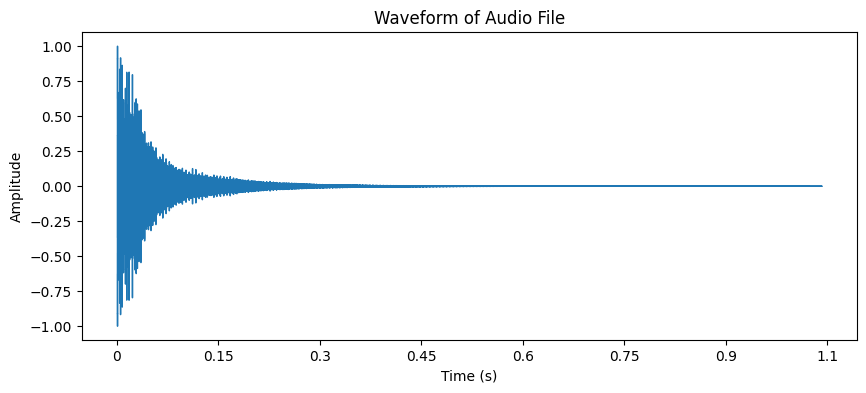

In [ ]:
def display_audio(audio_file_path):
  waveform, sample_rate = librosa.load(audio_file_path, sr=None)

  # Plot the waveform
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(waveform, sr=sample_rate)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title('Waveform of Audio File')
  plt.show()

In [ ]:
# HYPERPARAMETERS
duration_seconds = 4
sample_rate = 22050
hyper_params = {
    'duration': duration_seconds*sample_rate,
     'n_mels': 128,
    'hop_length': 512,
    'n_fft': 2048,
    'fmin': 20
}

model_params = {
    'num_epochs': 50,
    'batch_size': 64,
    'learning_rate': 0.001,
    'num_clases': 10,
    'eta_min': 1e-5,
    't_max': 10
}

In [ ]:
duration_df = pd.DataFrame(columns=['Duration'])

# Iterate over each waveform in the list and get its duration
for i, waveform in enumerate(train_data):
    duration = librosa.get_duration(y=waveform)
    duration_df.loc[i] = duration

# Use .describe() to get summary statistics
summary_stats = duration_df.describe()

print(summary_stats)

          Duration
count  4374.000000
mean      5.866536
std       3.327365
min       0.120000
25%       3.231746
50%       5.549410
75%       8.000000
max      34.829932


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

In [ ]:
# RESNETS:
class BasicBlock(nn.Module):

  expansion=1 # expansion is 1 as there is no expansion factor is basic block

  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):

    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False) # 3x3 Conv Layer
    self.bn1 = nn.BatchNorm2d(num_features = out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False)
    self.bn2 = nn.BatchNorm2d(num_features=out_channels)
    self.downsample = downsample

  def forward(self, x):

    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)

    if self.downsample is not None:
      identity = self.downsample(x)

    x += identity

    return (self.relu(x))


class BottleNeckBlock(nn.Module):

  expansion = 4

  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):

    super().__init__()

    base_width = 64

    width = int(out_channels * (base_width / 64.)) * 1

    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=width, kernel_size=1, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features=width)
    self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(num_features = width)
    self.conv3 = nn.Conv2d(in_channels=width, out_channels=width * self.expansion , kernel_size=1, stride=stride, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(num_features = width * self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x):

    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    if self.downsample is not None:
      identity = self.downsample(x)
    x+= identity

    return (self.relu(x))

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = F.relu(out)
        return out

class ResNet(nn.Module):

  def __init__(self, block, layers, num_classes):

    super().__init__()

    self.in_channels = 64

    # resnet stem
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features = self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    #res-blocks
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    #classifier block
    self.adppool = nn.AdaptiveAvgPool2d((2,2))
    self.classifier = nn.Linear(in_features=512 * block.expansion, out_features = num_classes)

  def _make_layer(self, block, out_channels, blocks, stride=1):

    downsample = None

    if stride!=1 or self.in_channels != out_channels * block.expansion:

      downsample = nn.Sequential(
          nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(num_features=out_channels * block.expansion)
    )

    layers=[]

    layers.append(block(self.in_channels, out_channels, stride, downsample))

    self.in_channels = out_channels * block.expansion

    for i in range(1, blocks):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)



  def forward(self, x):

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.adppool(x)
    x = torch.flatten(x, 1)

    return self.classifier(x)


class ExtendedResNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 3)
        self.layer2 = self.make_layer(64, 128, 4, stride=2)
        self.layer3 = self.make_layer(128, 256, 6, stride=2)
        self.layer4 = self.make_layer(256, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
